# Data Modeling
I utilized machine learning in order to create several models in order to predict which subreddit a post originated from based on its text. I created models for both predictive and inferential purposes, in order to provide the most information and utility. The models are different for these purposes due to the dictionary of "stop words" that I use for each, which will be explained in more detail in their respective sections (stop words are words that are removed from the data before analysis and modeling).

 - [Predictive Models](#Predictive-Models)  
 - [Inferential Models](#Inferential-Models)
 - [Inferential Models: No Gaming Stop Words](#Inferential-Models:-No-Gaming-Stop-Words)

In [25]:
# Import relevant libraries

import numpy as np
import pandas as pd
import p3_functions as pf
import general_functions as lf
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix

In [2]:
%%capture

# Retrieves the dataframe and stop words from the cleaning/EDA notebook. If those files aren't stored, then runs that file in order to create those objects, then retrieves them

try:
    %store -r df
    %store -r all_cards
except:
    %run ./p3_collection.ipynb
    %store -r df
    %store -r all_cards

In [3]:
# Create our training and test data sets for modeling
tcgs = ['Magic', 'Eternal','Hearthstone']

xtrain, xtest, ytrain, ytest = train_test_split(df['ptitle'], df['sub'], random_state=42)

## Predictive Models
For the purposes of prediction, I do not remove any words outside of the default stop words provided by the Python NLTK library. This is to preserve as much of the raw information as possible in order to generate the best possible predictions. I choose to use two classifiers here: a multinomial naive Bayes and a random forest classifier. Multinomial naive Bayes classifiers are useful due to their speed and versatility, as they can be easily applied to a number of problems, and thus serves as a useful starting point here.

In [4]:
# Create a grid search for optimal vectorizer and alpha for a multinomial naive Bayes classifier
# Fit the best model and generate the top 10 words for identification of each subreddit, as well as the CV and test scores

nbgrid = GridSearchCV(Pipeline([('tv', TfidfVectorizer(stop_words='english')), ('nb', MultinomialNB())]),
                      param_grid={'tv__max_df':[0.6,0.8,1],
                                  'tv__min_df':[1,5,10],
                                  'nb__alpha':[0.01,0.01,1,10,100]}, n_jobs=3)
nbgrid.fit(xtrain,ytrain)
print(f'Naive Bayes grid score: {round(nbgrid.best_score_,4)}\nTest score: {round(nbgrid.score(xtest,ytest),4)}\nBest Parameters:')
for key in nbgrid.best_params_:
    print(f'\t{key}: {nbgrid.best_params_[key]}')

Naive Bayes grid score: 0.8108
Test score: 0.8153
Best Parameters:
	nb__alpha: 1
	tv__max_df: 0.6
	tv__min_df: 1


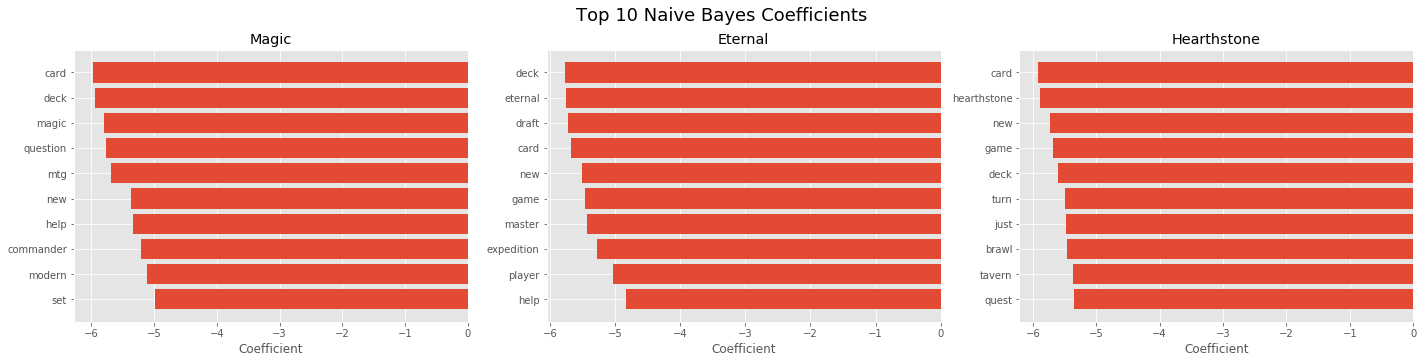

In [5]:
top_nb = pf.simple_grid_top(nbgrid, ['nb','tv'])
lf.subplot(['barh']*3, [range(10)]*3, tcgs, ['Coefficient']*3, [list(top_nb[x][:10][::-1]) for x in tcgs], [list(top_nb[x+' coef'][:10]) for x in tcgs], 'Top 10 Naive Bayes Coefficients', 24)

The naive Bayes model can classify a post with around 80% accuracy, which is not unexpected, as each game has numerous game specific terms that would only apply or appear in its own particular subreddit. For example, while all of the games utilize a resource system, Eternal refers to its resource as "influence" which are generated by "sigil" cards. Magic has a very similar mechanic, but refers to these resources as "mana" and "lands" respectively. While both fulfill a very similar function, they are referred to by unique names for each game. 

When examining the specific words associated with each game, the name of the game itself is, of course, one of the top identifiers. Surprisingly, a number of very generic terms such as "card" and "deck" are rated highly for each game. What is more interesting is that game modes in particular seem to be the best indicators for each subreddit. For example, "draft" and "expedition" are top terms for Eternal, while Magic identifies with "commander" and "modern," and Hearthstone is associated with its tavern brawl. This is logical, as these formats are the broadest sub-categories for each game, and will have more posts associated with them then discussion about a single card or mechanic. Of note is that drafting is a format for both Eternal and Magic, but is more strongly associated with Eternal from this data, implying that there is a greater interest in that style of play for Eternal players.

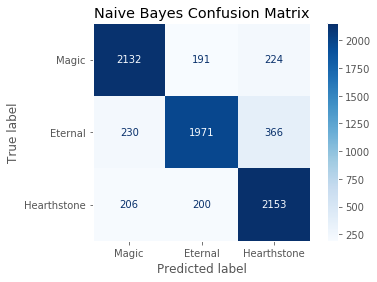

In [37]:
# Create confusion matrix for the NB model

np.set_printoptions
disp = plot_confusion_matrix(nbgrid, xtest, ytest, display_labels=['Magic','Eternal','Hearthstone'], cmap='Blues', values_format='')
disp.ax_.set_title('Naive Bayes Confusion Matrix')
disp.ax_.grid(False);

The confusion matrix shows that I hit approximately 77% specificity for Eternal posts, which is in line with the overall accuracy of the model. This is indicative of how successful the branding for the game; the more unique and distinguishable the game becomes, the more easily models will be able to determine true positives for the game. Of course, tuning the model further could also bring this specificity up

In [6]:
# Create a grid search for optimal vectorizer and leaf parameters for a random forest classifier
# Fit the best model and generate the top 10 words for identification of each subreddit, as well as the CV and test scores

rfgrid = GridSearchCV(Pipeline([('tv', TfidfVectorizer(stop_words='english')), ('rf', RandomForestClassifier(n_jobs=3))]),
                      param_grid={'tv__max_df':[0.6,0.8,1],
                                  'tv__min_df':[1,5,10],
                                  'rf__n_estimators':[50,100],
                                  'rf__min_samples_split':[2,3],
                                  'rf__min_samples_leaf':[1,2]}, n_jobs=3)
rfgrid.fit(xtrain,ytrain)
print(f'Random Forest grid score: {round(rfgrid.best_score_,4)}\nTest score: {round(rfgrid.score(xtest,ytest),4)}\nBest Parameters:')
for key in rfgrid.best_params_:
    print(f'\t{key}: {rfgrid.best_params_[key]}')

Random Forest grid score: 0.7707
Test score: 0.7854
Best Parameters:
	rf__min_samples_leaf: 1
	rf__min_samples_split: 3
	rf__n_estimators: 100
	tv__max_df: 0.8
	tv__min_df: 1


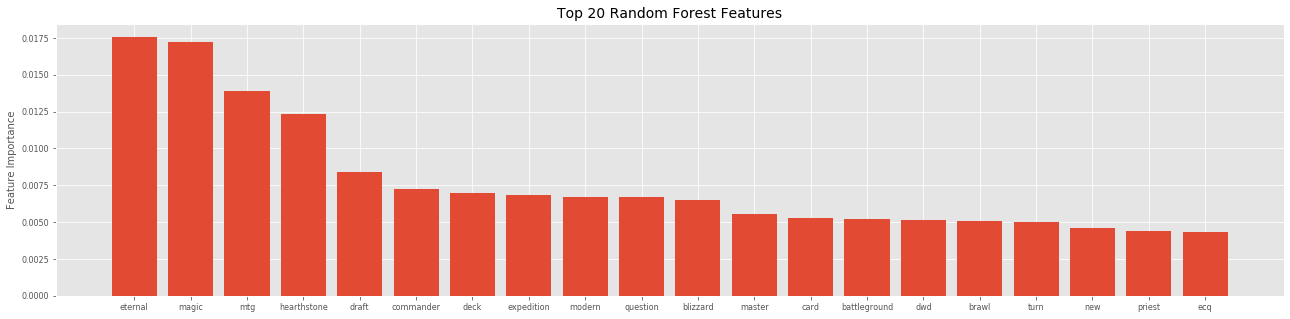

In [7]:
top_rf = pf.simple_grid_top(rfgrid, ['rf','tv'], values='features')
lf.create_bar(list(top_rf['Coefficients'][:20]), 'Top 20 Random Forest Features', ylabel='Feature Importance', ticks=list(top_rf.index)[:20], size=(22,5))

Unsurprisingly, the optimal random forest classifier returns nearly all game-specific words for its top twenty features. In particular, the names of each game (Eternal, Magic/MTG, and Hearthstone) are the top four, with feature importance values much higher than all of the others. While the random forest had a slightly worse accuracy, this is likely due to the minimal number of parameters tested, which was done in order to expedite processing time, as generating large numbers of trees with the number of vectorized features takes a much longer amount of time.

## Inferential Models
To build my models for inference, I attempt to remove as many game-specific terms as I can. While these words are very useful for predicting to which subreddit a post belongs, they are not very useful for identifying more general differences between the three games' communities. As such, words from card names, game formats, game mechanics, and other such categories are all added to the stop word list. In order to compensate for the expected drop in accuracy, as well as to increase confidence in the results, I tested six different types of classifiers for inferential purposes:
- Naive Bayes
- Logistic regression
- Linear SVM
- Random forest
- Gradient boost
- Ada boost

In [8]:
# Lists of general tcg words and words related to each game are added to the card list words as well as the default english stop words

gen_words = ['play','player','game','tcg','card', 'cards', 'mtg', 'hearthstone','eternal', 'deck', 'decks', 'sub', 'gathering', 'blizzard', 'magic', 'dwd', 'wotc']
eternal_words = ['direwolf','eternalwarcry','shiftstone','relic','dark','flame','echo','wizard','faction','master','influence','unit','premium','reckoning','foa','defiance','homecoming','frontier','trials','grodov','xulta','fox','firelight','pbf','echoes','eternity','eoe','ets','ecl','ecq','ewc','fire','time','justice','primal','shadow','jennev','ixtun','winchest','kerendon','auralian','campaign','puzzles','gauntlet','forge','event','casual','ranked','draft','expedition','praxis','rakano','skycrag','stonescar','combrei','elysian','xenan','hooru','argenport','feln']
mtg_words = ['enchantment','gp','magicfest','color','horizon','core','mythic','guilds','scg','mtga','white','black','red','blue','green','land','lands','gems','foil','ravnica','guild','dominaria','planeswalker','planeswalkers','creature','creatures','grn','rna','spark','war','eldraine','eld','theros','thb','ikoria','iko','mtgo','fnm','modern','standard','vintage','legacy','commander','edh','arena','sealed','pioneer','historic','azorius','dimir','rakdos','gruul','selesnya','orzhov','golgari','simic','izzet','boros','abzan','jeskai','sultai','mardu','temur','bant','esper','grixis','jund','naya']
hearthstone_words = ['mecha','murloc','murlocs','rastakhan','boomsday','dalaran','battleground','heist','dust','minion','minions','ashes','outland','aoo','initiate','dhi','galakrond','galakronds','awakening','descent','dragons','saviors','uldum','sou','dod','ros','witchwood','rumble','golden','wild','casual','adventure','tavern','brawl','hero','demon','hunter','druid','mage','paladin','priest','rogue','shaman','warlock','warrior']
full_stop = stopwords.words('english') + gen_words + eternal_words + mtg_words + hearthstone_words + all_cards

Due to the removal of game specific words, I conduct another grid search (using naive Bayes for speed) in order to determine which count vectorizer parameters are best. While this is only optimized for the naive Bayes model, for time efficiency, I used the same parameters for all five models

In [9]:
# Implement a new grid search using the full list of game stop words and test using a naive Bayes classifier

nbpgrid = GridSearchCV(Pipeline([('tv', TfidfVectorizer(stop_words=full_stop)), ('nb', MultinomialNB())]),
                      param_grid={'tv__max_df':[0.6,0.8,1],
                                  'tv__min_df':[1,5,10],
                                  'tv__max_features':[2000,3000,4000,5000]}, n_jobs=3)
nbpgrid.fit(xtrain,ytrain)
print(f'Naive Bayes grid score: {round(nbpgrid.best_score_,4)}\nTest score: {round(nbpgrid.score(xtest,ytest),4)}\nBest Parameters:')
for key in nbpgrid.best_params_:
    print(f'\t{key}: {nbpgrid.best_params_[key]}')

Naive Bayes grid score: 0.5846
Test score: 0.5909
Best Parameters:
	tv__max_df: 0.6
	tv__max_features: 5000
	tv__min_df: 1


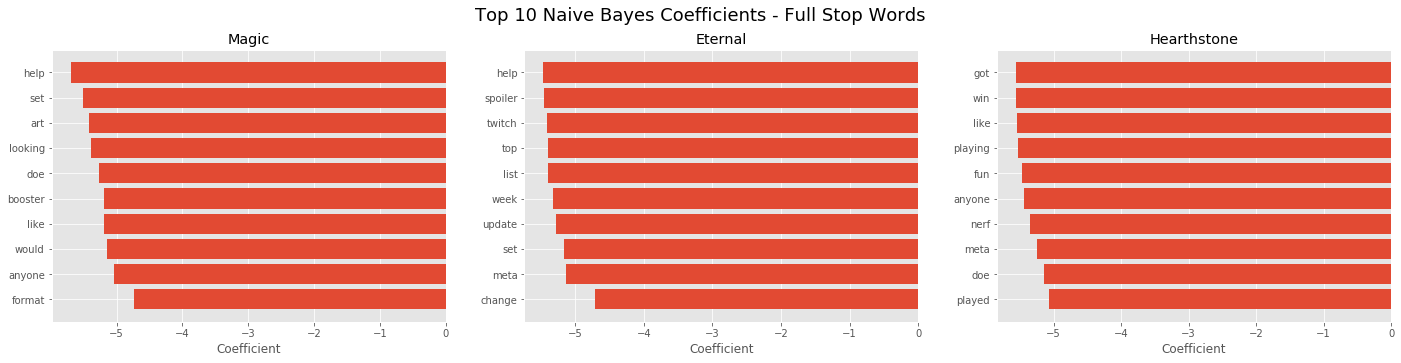

In [10]:
top_nbp = pf.simple_grid_top(nbpgrid, ['nb','tv'], values='coef')
lf.subplot(['barh']*3, [range(10)]*3, tcgs, ['Coefficient']*3, [list(top_nbp[x][:10][::-1]) for x in tcgs], [list(top_nbp[x+' coef'][:10]) for x in tcgs], 'Top 10 Naive Bayes Coefficients - Full Stop Words', 24)

As expected, accuracy drops sharply, to less than 60%. Furthermore, the top features of the model becomes essentially meaningless. While a few words are useful, such as twitch for Eternal, most of the top features are generic words such as "like," "would," and "playing." In order to combat this, I implemented a one-vs.-others approach in order to increase accuracy

In [11]:
# Fit the data using a vectorizer that removes the full list of game specific words

stop_tfv = TfidfVectorizer(stop_words=full_stop, max_features=5000, max_df=0.6)

tvtrain = stop_tfv.fit_transform(xtrain)
tvtest = stop_tfv.transform(xtest)

In [12]:
# Fit and test six types of models for each of the three games using the one-vs.-others approach, for a total of 18 models. Store the models and coefficients/feature importances in a dictionary

model_names = ['Naive Bayes', 'Logistic Regression', 'Linear SVM', 'Random Forest', 'Gradient Boost', 'Ada Boost']
models = {'Magic':{}, 'Eternal':{}, 'Hearthstone':{}}
for name in model_names:
    for tcgid in range(3):
        coefs, model = pf.onevs(name, tcgid, tvtrain, ytrain)
        models[tcgs[tcgid]][name] = {}
        models[tcgs[tcgid]][name]['Model'] = model
        models[tcgs[tcgid]][name]['Coefs'] = coefs
    print(f'{name} Classifier Eternal test score: {round(models["Eternal"][name]["Model"].score(tvtest, np.where(ytest == 1, 0 ,1)),4)}')

Naive Bayes Classifier Eternal test score: 0.7332
Logistic Regression Classifier Eternal test score: 0.7357
Linear SVM Classifier Eternal test score: 0.7377
Random Forest Classifier Eternal test score: 0.7206
Gradient Boost Classifier Eternal test score: 0.6995
Ada Boost Classifier Eternal test score: 0.7061


Even after employing the one-vs.-other approach, the accuracies for my models are still very low - they are only barely above baseline (66.67%). However, in order to glean any useful information, this is unfortunately necessary to find topics that are not related to terms only found in one of the three games. This is best shown when conducting this same process with only the default stop words, which is found at the end of this section.

In [13]:
# Create a dataframe for each game that combines the top features from each model into a single object

for tcg in tcgs:
    models[tcg]['df'] = pd.DataFrame(columns=model_names)
    for x in model_names:
        coef_df = pd.DataFrame(models[tcg][x]['Coefs'], index=stop_tfv.get_feature_names(), columns=['Coefs'])
        coef_df.sort_values(by='Coefs', ascending=False, inplace=True)
        models[tcg]['df'][x]=coef_df.index
    models[tcg]['df']['Naive Bayes'] = models[tcg]['df']['Naive Bayes'][::-1]
models['Eternal']['df'].head(10)

,Naive Bayes,Logistic Regression,Linear SVM,Random Forest,Gradient Boost,Ada Boost
0,stance,scarlatch,highlight,twitch,twitch,sunday
1,versus,chronicle,scarlatch,spoiler,thread,aggro
2,horrendous,highlight,chronicle,top,list,chronicle
3,crankypanda,fjs,twitch,highlight,top,art
4,tbf,xbox,switch,list,highlight,help
5,stun,exalted,achievement,help,podcast,twitch
6,brewed,leaderboard,fjs,change,spoiler,list
7,vet,achievement,exalted,update,booster,monday
8,tcgcthulhu,farming,overwhelm,week,scarlatch,check
9,bsh,gunslinger,wednesday,podcast,monday,month


Looking at the top 10 features for predicting Eternal posts from each of the models, it is apparent that there are large discrepancies between the different models. There are, however, a few terms that are seen in multiple models, such as Scarlatch, twitch, and highlight, which suggest that these words do carry weight despite the weaknesses of the individual models. In particular the naive Bayes model is much more out of sync in terms of the words it assigns higher coefficients to. For this reason, I choose to omit the naive Bayes model when creating the aggregate ranks. While the initial grid optimization was conducted with that type of model, because relatively few parameters were tested, it should still be adequate for our purposes.

In [14]:
# Calculate aggregate rank for each feature (summation of the words position in all models except naive Bayes)
# Create a new column in the feature dataframe for each game with the features sorted by aggregate rank
# Naive Bayes was omitted due to its large discrepancies with the rest of the models

for tcg in tcgs:
    agg = {x:0 for x in stop_tfv.get_feature_names()}

    for z in ['Logistic Regression', 'Linear SVM', 'Random Forest', 'Gradient Boost', 'Ada Boost']:
        for t in range(len(stop_tfv.get_feature_names())):
            agg[models[tcg]['df'][z][t]] += t

    agg = pd.DataFrame.from_dict([agg]).transpose()
    agg.columns = ['Total Rank']
    agg.sort_values(by=['Total Rank'], inplace=True)
    models[tcg]['Aggregate Rank'] = agg

In [15]:
# Create a single dataframe containing the aggregate rank features with all three games top features

agg_df = pd.DataFrame(columns=tcgs)
for x in tcgs:
    agg_df[x] = models[x]['Aggregate Rank'].index
agg_df.head(10)

,Magic,Eternal,Hearthstone
0,booster,scarlatch,class
1,prerelease,twitch,bob
2,lgs,highlight,lethal
3,ruling,thread,highlander
4,reprint,xbox,nerfs
5,myb,achievement,otk
6,edition,chronicle,hp
7,sleeve,monday,odd
8,maro,sunday,solo
9,paper,farming,til


To combine all of our models results into a single score, I calculated the aggregate rank for each feature by adding together the position of each feature from the five selected models. The features were then sorted by this aggregate rank in order to determine which features were overall more important across all the models. From this, I found several community topics in Eternal that may be worth looking into further. Notably, the topics of Scarlatch and twitch, who is a developer and the popular gaming stream site, suggesting that they have a (relatively) larger impact on the Eternal community. The other terms of interest are Xbox and chronicle (Eternal: Chronicles of the Throne is a tie-in board game) which implies that these platforms are also distinguishing features that differentiate Eternal from the others.

For the other two subs, Magic has many features relating to the fact that it is the only game that exists in a physical form (paper, misprint, lgs (Local Game Store) and reprint), which helps give Magic a stronger unique identity. Hearthstone, however, has very nondescript words as its top features, making it hard to draw inferences from.

## Inferential Models: No Gaming Stop Words
This section highlights the necessity for removing game specific stop words. The process in this section is the exact same process that was conducted above, with only variable names changing in order to create new objects so as not to overwrite the previous results. If I use only the default english stop words, my model accuracies improve dramatically, especially since these are also using the one-vs.-others approach. Four of the models score above 85%, nearly 20% above the baseline, while the other two are still decent at around 78%. However, when I examine the top ranked features, the list is populated with terms that do not provide any useful insight. For example, all three companies, Wizards of the Coast (wotc), Dire Wolf Digital (dwd) and Blizzard all appear in their respective game's list. And of course, each game's name is among the top three features in its own list. This is hardly surprising, but it does not tell me anything that I did not already know. Thus, I sacrifice model accuracy in order to hopefully glean useful information, relying on the multi-method approach to provide some additional confidence to compensate for the weakness of the fit.

In [16]:
reg = TfidfVectorizer(stop_words='english', max_features=5000, max_df=0.6)
regtrain = reg.fit_transform(xtrain)
regtest = reg.transform(xtest)

model_names = ['Naive Bayes', 'Logistic Regression', 'Linear SVM', 'Random Forest', 'Gradient Boost', 'Ada Boost']
mods = {'Magic':{}, 'Eternal':{}, 'Hearthstone':{}}
for name in model_names:
    for tcgid in range(3):
        coefs, model = pf.onevs(name, tcgid, regtrain, ytrain)
        mods[tcgs[tcgid]][name] = {}
        mods[tcgs[tcgid]][name]['Model'] = model
        mods[tcgs[tcgid]][name]['Coefs'] = coefs
    print(f'{name} Classifier Eternal test score: {round(mods["Eternal"][name]["Model"].score(regtest, np.where(ytest == 1, 0 ,1)),4)}')

Naive Bayes Classifier Eternal test score: 0.8649
Logistic Regression Classifier Eternal test score: 0.8716
Linear SVM Classifier Eternal test score: 0.8712
Random Forest Classifier Eternal test score: 0.8566
Gradient Boost Classifier Eternal test score: 0.7764
Ada Boost Classifier Eternal test score: 0.785


In [17]:
for tcg in tcgs:
    mods[tcg]['df'] = pd.DataFrame(columns=model_names)
    for x in model_names:
        coef_df = pd.DataFrame(mods[tcg][x]['Coefs'], index=reg.get_feature_names(), columns=['Coefs'])
        coef_df.sort_values(by='Coefs', ascending=False, inplace=True)
        mods[tcg]['df'][x]=coef_df.index
    mods[tcg]['df']['Naive Bayes'] = mods[tcg]['df']['Naive Bayes'][::-1]
mods['Eternal']['df'].head(10)

,Naive Bayes,Logistic Regression,Linear SVM,Random Forest,Gradient Boost,Ada Boost
0,ets,eternal,eternal,eternal,eternal,game
1,peacekeeper,dwd,dwd,draft,draft,mtg
2,partidas,expedition,gauntlet,expedition,expedition,ravnica
3,reunion,gauntlet,expedition,dwd,master,ets
4,fjs,ecq,ecq,master,dwd,arena
5,passage,campaign,unit,ecq,ecq,eldraine
6,bazaar,unit,campaign,gauntlet,league,draft
7,concern,fox,draft,league,gauntlet,magic
8,stinger,defiance,premium,deck,magic,land
9,jekk,premium,vara,event,campaign,rogue


In [18]:
for tcg in tcgs:
    agg = {x:0 for x in reg.get_feature_names()}

    for z in ['Logistic Regression', 'Linear SVM', 'Random Forest', 'Gradient Boost', 'Ada Boost']:
        for t in range(len(reg.get_feature_names())):
            agg[mods[tcg]['df'][z][t]] += t

    agg = pd.DataFrame.from_dict([agg]).transpose()
    agg.columns = ['Total Rank']
    agg.sort_values(by=['Total Rank'], inplace=True)
    mods[tcg]['Aggregate Rank'] = agg

In [19]:
reg_df = pd.DataFrame(columns=tcgs)
for x in tcgs:
    reg_df[x] = mods[x]['Aggregate Rank'].index
reg_df.head(10)

,Magic,Eternal,Hearthstone
0,modern,draft,hearthstone
1,commander,eternal,hunter
2,magic,campaign,blizzard
3,mtg,expedition,priest
4,booster,ecq,golden
5,wotc,dwd,battleground
6,eldraine,gauntlet,rogue
7,edh,league,tavern
8,land,fox,quest
9,mythic,master,warrior
